In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/biasbios")
sys.path.append("../data/embeddings/biasbios")
import classifier
import svm_classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
import copy
import pandas as pd
from gensim.models import FastText
import time
from gensim.scripts.glove2word2vec import glove2word2vec

STOPWORDS = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

In [2]:


def load_dataset(path):
    
    with open(path, "rb") as f:
        
        data = pickle.load(f)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter


In [3]:
train = load_dataset("../data/biasbios/hila/train.pickle")
dev = load_dataset("../data/biasbios/hila/dev.pickle")
test = load_dataset("../data/biasbios/hila/test.pickle")

#w2i, i2w = load_dictionary("../data/biasbios/word2index.txt")
p2i, i2p = load_dictionary("../data/biasbios/profession2index.txt")
g2i, i2g = load_dictionary("../data/biasbios/gender2index.txt")
counter = count_profs_and_gender(train+dev+test)

In [4]:
f,m = 0., 0.
prof2fem = dict()

for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

0.46286566875856267
{'photographer': 0.35721920736720936, 'poet': 0.49080017115960634, 'journalist': 0.49488721804511276, 'professor': 0.45118956904580476, 'software_engineer': 0.1576889661164205, 'psychologist': 0.6223011751844766, 'architect': 0.23712053792148718, 'surgeon': 0.14857228961048746, 'attorney': 0.38316925813475633, 'painter': 0.4579886246122027, 'nurse': 0.9085446207369142, 'physician': 0.507688318423441, 'interior_designer': 0.8086124401913876, 'teacher': 0.603111879476414, 'accountant': 0.36818825194621374, 'chiropractor': 0.26558891454965355, 'dentist': 0.35589474411216243, 'model': 0.8283124500133298, 'filmmaker': 0.3295762590954487, 'yoga_teacher': 0.8454600120264583, 'composer': 0.16392857142857142, 'pastor': 0.24052132701421802, 'personal_trainer': 0.45670391061452514, 'dj': 0.1420875420875421, 'rapper': 0.09665955934612651, 'dietitian': 0.9273504273504274, 'comedian': 0.21150410861021793, 'paralegal': 0.8483305036785512}


In [5]:
print(p2i)

{'accountant': 0, 'architect': 1, 'attorney': 2, 'chiropractor': 3, 'comedian': 4, 'composer': 5, 'dentist': 6, 'dietitian': 7, 'dj': 8, 'filmmaker': 9, 'interior_designer': 10, 'journalist': 11, 'model': 12, 'nurse': 13, 'painter': 14, 'paralegal': 15, 'pastor': 16, 'personal_trainer': 17, 'photographer': 18, 'physician': 19, 'poet': 20, 'professor': 21, 'psychologist': 22, 'rapper': 23, 'software_engineer': 24, 'surgeon': 25, 'teacher': 26, 'yoga_teacher': 27}


### get input representatons 

In [6]:

def load_word_vectors(fname = "../data/embeddings/vecs.filtered.with_gendered.glove.txt"):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words


def get_embeddings_based_dataset(data: List[dict], word2vec_model, p2i, filter_stopwords = False):
    
    X, Y = [], []
    unk, total = 0., 0.
    unknown = []
    
    for entry in tqdm.tqdm(data, total = len(data)):
        
        y = p2i[entry["p"]]
        words = entry["hard_text"].split(" ")
        if filter_stopwords:
            words = [w for w in words if w.lower() not in STOPWORDS]
            
        bagofwords = np.sum([word2vec_model[w] if w in word2vec_model else word2vec_model["unk"] for w in words], axis = 0)
        #print(bagofwords.shape)
        X.append(bagofwords)
        Y.append(y)
        total += len(words)
        
        unknown_entry = [w for w in words if w not in word2vec_model]
        unknown.extend(unknown_entry)
        unk += len(unknown_entry)
    
    X = np.array(X)
    Y = np.array(Y)
    print("% unknown: {}".format(unk/total))
    return X,Y,unknown

def get_BOW_based_dataset(data: List[dict], w2i):
    
    vectorizer = DictVectorizer(sparse = True)
    X, Y = [], []
    unk, total = 0., 0.
    data_dicts = []
    unknown = []
    
    for entry in tqdm.tqdm(data, total = len(data)):
        text, start, y = entry["text"], entry["start"], entry["p"]
        #text = text.lower()
        words = text[start + 1:].split(" ")
        entry_dict = {w:w2i[w] if w in w2i else w2i["<UNK>"] for w in words}
        data_dicts.append(entry_dict)
        Y.append(y)
        
        total += len(words)
        unknown_entry = [w for w in words if w not in w2i]
        unk += len([w for w in words if w not in w2i])
        unknown.extend(unknown_entry)
    
    print("% unknown: {}".format(unk/total))
    X = vectorizer.fit_transform(data_dicts)
    return X,Y, unknown
    
def get_bert_based_dataset(data: List[dict], p2i):
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    model = BertModel.from_pretrained('bert-base-cased').cuda()
    model.eval()
    
    X, Y = [], []
    cls_lst = ['[CLS]']
    sep_lst = ['[SEP]']
    
    for entry in tqdm.tqdm(data, total = len(data)):
        text, y = entry["hard_text"], p2i[entry["p"]]
        #text = text.lower()            
        tokenized_text = cls_lst + tokenizer.tokenize(text)[:500] + sep_lst    
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).cuda()
        with torch.no_grad():
              outputs = model(tokens_tensor)[0]
              out_np = outputs.detach().cpu().numpy()
              out_np = out_np.squeeze(0)
              BOW = out_np[-1][:] #np.sum(out_np, axis = 0)
              X.append(BOW)
              Y.append(y)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X,Y

In [17]:
#word2vec, vecs, words = load_word_vectors("../data/embeddings/wiki-news-300d-1M-subword.vec") #load_word2vec()
word2vec, vecs, words = load_word_vectors("../data/embeddings/crawl-300d-2M.vec")
#path = "../data/embeddings/crawl-300d-2M-subword.bin"
#word2vec = gensim.models.fasttext.load_facebook_vectors(path)
#word2vec.init_sims(replace = True)
#X_train, Y_train = get_BOW_based_dataset(train, w2i)
#X_devword2vec.init_sims(replace = True), Y_dev = get_BOW_based_dataset(dev, w2i) 


In [8]:
#word2vec.init_sims(replace = True)

In [18]:
embeds =  True

if embeds:
    X_train, Y_train, unknown_train = get_embeddings_based_dataset(train, word2vec, p2i)
    X_dev, Y_dev, unknown_dev =  get_embeddings_based_dataset(dev, word2vec, p2i)
    X_test, Y_test, unknown_test =  get_embeddings_based_dataset(test, word2vec, p2i)
else:
    
    X_train, Y_train, unk = get_bert_based_dataset(train, p2i)
    X_dev, Y_dev, unk =  get_bert_based_dataset(dev, p2i)
    X_test, Y_test, unk =  get_bert_based_dataset(test, p2i)
#X_train, Y_train = get_bert_based_dataset(train)

  1%|▏         | 579/39343 [00:00<00:06, 5784.63it/s]

% unknown: 0.010607034482170177


  1%|          | 587/98356 [00:00<00:16, 5856.64it/s]

% unknown: 0.010464651863141643


100%|██████████| 98356/98356 [00:17<00:00, 5483.93it/s]


% unknown: 0.010732943116883753


In [12]:
mean_x = np.mean(X_train, axis = 0, keepdims = True)
std_x = np.std(X_train, axis = 0, keepdims = True)

X_train = (X_train-mean_x)/std_x
X_dev = (X_dev-mean_x)/std_x


print(np.linalg.norm(X_dev[0]))
print("len train: {}; len dev: {}; len test: {}".format(len(train), len(dev), len(test)))

12.629288
len train: 255724; len dev: 39343; len test: 98356


In [13]:
X_test = (X_test-mean_x)/std_x


In [ ]:
d = load_dataset("../data/biasbios/BIOS.OLD.pkl")
d2 = load_dataset("../data/biasbios/BIOS.pkl")
len(d)

In [20]:
#clf = LinearSVC(max_iter = 10) #LogisticRegression()
#clf = SGDClassifier(warm_start = True, loss = 'log', n_jobs = 64, max_iter = 250, random_state = 0)

MLP = False

if MLP:
    clf = MLPClassifier(activation = "identity", hidden_layer_sizes = (100,), max_iter = 15)
else:
    clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 5, n_jobs = 64, random_state = 1)

start = time.time()
idx = np.random.rand(X_train.shape[0]) < 1.0
clf.fit(X_train[idx], Y_train[idx])
print("time: {}".format(time.time() - start))
print(clf.score(X_dev, Y_dev))
clf_original = copy.deepcopy(clf)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 47 seconds
time: 48.423277378082275


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   47.7s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   47.7s finished


0.7832397122741022


In [21]:
print(clf.score(X_test, Y_test))


0.7810708040180568


#### Confusion Matrix

In [ ]:
"""
y_hat = clf.predict(X_dev)
cm = sklearn.metrics.confusion_matrix(Y_dev,y_hat)
labels = [i2p[i] for i in range(len(i2p))]
"""

In [69]:

"""
df_cm = pd.DataFrame(cm, index = labels, columns = labels)
#plt.figure(figsize = (10,7))
sn.set(font_scale=0.3)#for label size
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.savefig("confusion.png", dpi = 600)
plt.show()
 """
#clf = copy.deepcopy(clf_original)

#MLP = True
#clf = copy.deepcopy(clf_original)

### perform debiasing

In [30]:
def get_projection_matrix(num_clfs, X_train, Y_train, X_dev, Y_dev, Y_train_task, Y_dev_task, dim):

    is_autoregressive = True
    min_acc = 0.
    noise = False
    dim = 300
    n = num_clfs
    random_subset = 1
    start = time.time()
    TYPE= "sgd"
    
    if MLP:
        x_train_gender = np.matmul(X_train, clf.coefs_[0]) + clf.intercepts_[0]
        x_dev_gender = np.matmul(X_dev, clf.coefs_[0]) + clf.intercepts_[0]
    else:
        x_train_gender = X_train.copy()
        x_dev_gender = X_dev.copy()
        
    
    if TYPE == "sgd":
        gender_clf = SGDClassifier
        params = {'loss': 'log', 'max_iter': 300, 'fit_intercept': False, 'class_weight': None, 'n_jobs': 100}
    else:
        gender_clf = LinearSVC
        params = {'max_iter': 1000, 'fit_intercept': False, 'class_weight': "balanced", "dual": False}
        
    P = debias.get_debiasing_projection(gender_clf, params, n, dim, is_autoregressive, min_acc,
                                              x_train_gender, Y_train, x_dev_gender, Y_dev, noise=noise, random_subset = random_subset,
                                       Y_train_main=Y_train_task, Y_dev_main=Y_dev_task)
    print("time: {}".format(time.time() - start))
    return P

prof2P = dict()
P_all = np.eye(300)
""" 
for prof in p2i.keys():

    num_clfs = 30
    Y_dev_gender = np.array([g2i[d["g"]] for d in dev])
    Y_train_gender = np.array([g2i[d["g"]] for d in train])
    rel_idx_train = Y_train == p2i[prof]
    rel_idx_dev = Y_dev == p2i[prof]
    

    P = get_projection_matrix(num_clfs, X_train[rel_idx_train], Y_train_gender[rel_idx_train], X_dev[rel_idx_dev], Y_dev_gender[rel_idx_dev], dim = 300)
    prof2P[prof] = P
    P_all = P_all.dot(P)
"""   

num_clfs = 100
Y_dev_gender = np.array([g2i[d["g"]] for d in dev])
Y_train_gender = np.array([g2i[d["g"]] for d in train])
#idx = np.random.rand(X_train.shape[0]) < 1.
P = get_projection_matrix(num_clfs, X_train, Y_train_gender, X_dev, Y_dev_gender, Y_train, Y_dev, 300)


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0, Accuracy: 0.9777306468716861


  1%|          | 1/100 [00:01<03:03,  1.85s/it]

Iteration 1, Accuracy: 0.9377162629757786


  2%|▏         | 2/100 [00:03<03:07,  1.92s/it]

Iteration 2, Accuracy: 0.7728658536585366


  3%|▎         | 3/100 [00:05<02:48,  1.73s/it]

Iteration 3, Accuracy: 0.8502202643171806


  4%|▍         | 4/100 [00:06<02:29,  1.56s/it]

Iteration 4, Accuracy: 0.7785714285714286


  5%|▌         | 5/100 [00:07<02:19,  1.46s/it]

Iteration 5, Accuracy: 0.45714285714285713


  6%|▌         | 6/100 [00:08<02:11,  1.40s/it]

Iteration 6, Accuracy: 0.6918918918918919


  7%|▋         | 7/100 [00:10<02:10,  1.41s/it]

Iteration 7, Accuracy: 0.24820659971305595


  8%|▊         | 8/100 [00:11<02:13,  1.45s/it]

Iteration 8, Accuracy: 0.24669603524229075


  9%|▉         | 9/100 [00:13<02:05,  1.38s/it]

Iteration 9, Accuracy: 0.774390243902439


 10%|█         | 10/100 [00:14<01:55,  1.28s/it]

Iteration 10, Accuracy: 0.6666666666666666


 11%|█         | 11/100 [00:15<01:56,  1.31s/it]

Iteration 11, Accuracy: 0.8194993412384717


 12%|█▏        | 12/100 [00:17<02:01,  1.38s/it]

Iteration 12, Accuracy: 0.7614035087719299


 13%|█▎        | 13/100 [00:18<01:55,  1.33s/it]

Iteration 13, Accuracy: 0.43612334801762115


 14%|█▍        | 14/100 [00:19<01:50,  1.29s/it]

Iteration 14, Accuracy: 0.6996539792387543


 15%|█▌        | 15/100 [00:21<02:08,  1.51s/it]

Iteration 15, Accuracy: 0.7607843137254902


 16%|█▌        | 16/100 [00:22<01:57,  1.40s/it]

Iteration 16, Accuracy: 0.6792929292929293


 17%|█▋        | 17/100 [00:28<03:42,  2.68s/it]

Iteration 17, Accuracy: 0.8796992481203008


 18%|█▊        | 18/100 [00:29<03:00,  2.20s/it]

Iteration 18, Accuracy: 0.6198198198198198


 19%|█▉        | 19/100 [00:30<02:40,  1.98s/it]

Iteration 19, Accuracy: 0.7929515418502202


 20%|██        | 20/100 [00:31<02:18,  1.74s/it]

Iteration 20, Accuracy: 0.7753259779338014


 21%|██        | 21/100 [00:34<02:28,  1.88s/it]

Iteration 21, Accuracy: 0.7812911725955204


 22%|██▏       | 22/100 [00:35<02:21,  1.81s/it]

Iteration 22, Accuracy: 0.7824561403508772


 23%|██▎       | 23/100 [00:37<02:11,  1.70s/it]

Iteration 23, Accuracy: 0.6862745098039216


 24%|██▍       | 24/100 [00:38<01:57,  1.55s/it]

Iteration 24, Accuracy: 0.267491926803014


 25%|██▌       | 25/100 [00:41<02:34,  2.07s/it]

Iteration 25, Accuracy: 0.5536332179930796


 26%|██▌       | 26/100 [00:44<02:43,  2.20s/it]

Iteration 26, Accuracy: 0.5832813474734873


 27%|██▋       | 27/100 [00:47<02:52,  2.36s/it]

Iteration 27, Accuracy: 0.6951219512195121


 28%|██▊       | 28/100 [00:48<02:36,  2.18s/it]

Iteration 28, Accuracy: 0.6588235294117647


 29%|██▉       | 29/100 [00:50<02:18,  1.95s/it]

Iteration 29, Accuracy: 0.7157132150886835


 30%|███       | 30/100 [00:59<04:52,  4.18s/it]

Iteration 30, Accuracy: 0.5801350542781434


 31%|███       | 31/100 [01:32<14:48, 12.88s/it]

Iteration 31, Accuracy: 0.8105726872246696


 32%|███▏      | 32/100 [01:34<10:39,  9.40s/it]

Iteration 32, Accuracy: 0.9020452099031216


 33%|███▎      | 33/100 [01:37<08:35,  7.70s/it]

Iteration 33, Accuracy: 0.7783350050150452


 34%|███▍      | 34/100 [01:39<06:39,  6.05s/it]

Iteration 34, Accuracy: 0.5477477477477477


 35%|███▌      | 35/100 [01:41<05:09,  4.75s/it]

Iteration 35, Accuracy: 0.9097744360902256


 36%|███▌      | 36/100 [01:43<03:58,  3.72s/it]

Iteration 36, Accuracy: 0.812051649928264


 37%|███▋      | 37/100 [01:44<03:13,  3.07s/it]

Iteration 37, Accuracy: 0.5642857142857143


 38%|███▊      | 38/100 [01:45<02:37,  2.54s/it]

Iteration 38, Accuracy: 0.5060975609756098


 39%|███▉      | 39/100 [01:47<02:12,  2.17s/it]

Iteration 39, Accuracy: 0.6144728633811604


 40%|████      | 40/100 [01:50<02:24,  2.41s/it]

Iteration 40, Accuracy: 0.6539634146341463


 41%|████      | 41/100 [01:52<02:14,  2.28s/it]

Iteration 41, Accuracy: 0.5858960763520679


 42%|████▏     | 42/100 [01:54<02:18,  2.39s/it]

Iteration 42, Accuracy: 0.7058823529411765


 43%|████▎     | 43/100 [01:56<01:59,  2.09s/it]

Iteration 43, Accuracy: 0.36128048780487804


 44%|████▍     | 44/100 [01:57<01:52,  2.01s/it]

Iteration 44, Accuracy: 0.8780487804878049


 45%|████▌     | 45/100 [01:59<01:39,  1.81s/it]

Iteration 45, Accuracy: 0.7294117647058823


 46%|████▌     | 46/100 [02:00<01:28,  1.64s/it]

Iteration 46, Accuracy: 0.6111111111111112


 47%|████▋     | 47/100 [02:05<02:26,  2.76s/it]

Iteration 47, Accuracy: 0.8589420654911839


 48%|████▊     | 48/100 [02:07<02:04,  2.40s/it]

Iteration 48, Accuracy: 0.5177610333692142


 49%|████▉     | 49/100 [02:11<02:20,  2.76s/it]

Iteration 49, Accuracy: 0.5691939482007009


 50%|█████     | 50/100 [02:40<08:55, 10.71s/it]

Iteration 50, Accuracy: 0.8431372549019608


 51%|█████     | 51/100 [02:41<06:25,  7.86s/it]

Iteration 51, Accuracy: 0.6957282038471146


 52%|█████▏    | 52/100 [02:48<06:00,  7.51s/it]

Iteration 52, Accuracy: 0.3039647577092511


 53%|█████▎    | 53/100 [02:49<04:26,  5.67s/it]

Iteration 53, Accuracy: 0.8105263157894737


 54%|█████▍    | 54/100 [02:51<03:22,  4.40s/it]

Iteration 54, Accuracy: 0.7813440320962889


 55%|█████▌    | 55/100 [02:52<02:43,  3.64s/it]

Iteration 55, Accuracy: 0.5146140394703972


 56%|█████▌    | 56/100 [03:02<03:56,  5.39s/it]

Iteration 56, Accuracy: 0.5450427780573729


 57%|█████▋    | 57/100 [03:05<03:27,  4.82s/it]

Iteration 57, Accuracy: 0.5208137447645098


 58%|█████▊    | 58/100 [03:33<08:10, 11.68s/it]

Iteration 58, Accuracy: 0.3403141361256545


 59%|█████▉    | 59/100 [03:35<05:53,  8.61s/it]

Iteration 59, Accuracy: 0.8185873605947955


 60%|██████    | 60/100 [03:37<04:25,  6.65s/it]

Iteration 60, Accuracy: 0.7168998923573735


 61%|██████    | 61/100 [03:40<03:40,  5.66s/it]

Iteration 61, Accuracy: 0.5847508334045645


 62%|██████▏   | 62/100 [04:15<09:08, 14.44s/it]

Iteration 62, Accuracy: 0.6371951219512195


 63%|██████▎   | 63/100 [04:17<06:35, 10.68s/it]

Iteration 63, Accuracy: 0.7279596977329975


 64%|██████▍   | 64/100 [04:19<04:49,  8.04s/it]

Iteration 64, Accuracy: 0.5674300254452926


 65%|██████▌   | 65/100 [04:20<03:35,  6.16s/it]

Iteration 65, Accuracy: 0.924812030075188


 66%|██████▌   | 66/100 [04:22<02:39,  4.71s/it]

Iteration 66, Accuracy: 0.5203824861600402


 67%|██████▋   | 67/100 [04:26<02:27,  4.48s/it]

Iteration 67, Accuracy: 0.801762114537445


 68%|██████▊   | 68/100 [04:27<01:54,  3.59s/it]

Iteration 68, Accuracy: 0.7287234042553191


 69%|██████▉   | 69/100 [04:29<01:32,  3.00s/it]

Iteration 69, Accuracy: 0.8658536585365854


 70%|███████   | 70/100 [04:30<01:16,  2.57s/it]

Iteration 70, Accuracy: 0.5165496489468405


 71%|███████   | 71/100 [04:33<01:16,  2.63s/it]

Iteration 71, Accuracy: 0.907427341227126


 72%|███████▏  | 72/100 [04:37<01:19,  2.85s/it]

Iteration 72, Accuracy: 0.5309511826874685


 73%|███████▎  | 73/100 [04:41<01:29,  3.31s/it]

Iteration 73, Accuracy: 0.8335724533715926


 74%|███████▍  | 74/100 [04:43<01:14,  2.85s/it]

Iteration 74, Accuracy: 0.41223671013039115


 75%|███████▌  | 75/100 [04:45<01:04,  2.59s/it]

Iteration 75, Accuracy: 0.8841463414634146


 76%|███████▌  | 76/100 [04:46<00:53,  2.21s/it]

Iteration 76, Accuracy: 0.6435129740518962


 77%|███████▋  | 77/100 [04:52<01:15,  3.29s/it]

Iteration 77, Accuracy: 0.8297872340425532


 78%|███████▊  | 78/100 [04:53<01:00,  2.74s/it]

Iteration 78, Accuracy: 0.5865139949109415


 79%|███████▉  | 79/100 [04:55<00:52,  2.52s/it]

Iteration 79, Accuracy: 0.45714285714285713


 80%|████████  | 80/100 [04:57<00:43,  2.17s/it]

Iteration 80, Accuracy: 0.6051154086088584


 81%|████████  | 81/100 [05:01<00:53,  2.79s/it]

Iteration 81, Accuracy: 0.4847560975609756


 82%|████████▏ | 82/100 [05:03<00:46,  2.59s/it]

Iteration 82, Accuracy: 0.6546712802768166


 83%|████████▎ | 83/100 [05:07<00:49,  2.90s/it]

Iteration 83, Accuracy: 0.9052744886975242


 84%|████████▍ | 84/100 [05:11<00:52,  3.31s/it]

Iteration 84, Accuracy: 0.4846846846846847


 85%|████████▌ | 85/100 [05:13<00:43,  2.89s/it]

Iteration 85, Accuracy: 0.6071428571428571


 86%|████████▌ | 86/100 [05:14<00:34,  2.44s/it]

Iteration 86, Accuracy: 0.617739898989899


 87%|████████▋ | 87/100 [05:23<00:55,  4.28s/it]

Iteration 87, Accuracy: 0.5407124681933843


 88%|████████▊ | 88/100 [05:25<00:43,  3.62s/it]

Iteration 88, Accuracy: 0.836441893830703


 89%|████████▉ | 89/100 [05:27<00:35,  3.20s/it]

Iteration 89, Accuracy: 0.5880681818181818


 90%|█████████ | 90/100 [05:36<00:49,  4.96s/it]

Iteration 90, Accuracy: 0.7529411764705882


 91%|█████████ | 91/100 [05:37<00:34,  3.88s/it]

Iteration 91, Accuracy: 0.5785714285714286


 92%|█████████▏| 92/100 [05:39<00:24,  3.11s/it]

Iteration 92, Accuracy: 0.5553334998750937


 93%|█████████▎| 93/100 [05:46<00:30,  4.41s/it]

Iteration 93, Accuracy: 0.5610687022900763


 94%|█████████▍| 94/100 [05:48<00:21,  3.64s/it]

Iteration 94, Accuracy: 0.8719512195121951


 95%|█████████▌| 95/100 [05:49<00:14,  2.95s/it]

Iteration 95, Accuracy: 0.7833500501504513


 96%|█████████▌| 96/100 [05:51<00:10,  2.61s/it]

Iteration 96, Accuracy: 0.635273544841369


 97%|█████████▋| 97/100 [06:00<00:13,  4.39s/it]

Iteration 97, Accuracy: 0.6126126126126126


 98%|█████████▊| 98/100 [06:01<00:07,  3.56s/it]

Iteration 98, Accuracy: 0.8352941176470589


 99%|█████████▉| 99/100 [06:03<00:02,  2.89s/it]

Iteration 99, Accuracy: 0.7852437417654808


100%|██████████| 100/100 [06:05<00:00,  3.65s/it]

time: 365.6921076774597


In [215]:
#clf.coefs_[0] =  clf.coefs_[0].dot(P)
P = np.mean(list(prof2P.values()), axis = 0)
P.shape

P = P_all.copy()

#### test model without finetuning

In [35]:
print(clf.score(X_dev.dot(P), Y_dev))
#print(clf.score(X_dev, Y_dev))

0.7664641740589178


### Perform finetuning

In [34]:
clf.fit(X_train.dot(P), Y_train)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 39 seconds


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   38.3s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   38.3s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5,
                   multi_class='multinomial', n_jobs=64, penalty='l2',
                   random_state=1, solver='sag', tol=0.0001, verbose=10,
                   warm_start=True)

#### test again

In [200]:

X_dev_after = X_dev.copy()
X_train_after = X_train.copy()

for prof, P in prof2P.items():
    idx = Y_dev == p2i[prof]
    X_dev_after[idx] = X_dev_after[idx].dot(P)
    
    idx_train = Y_train == p2i[prof]
    X_train_after[idx_train] = X_train_after[idx_train].dot(P)

print("before finetunine", clf.score(X_dev_after, Y_dev))
clf.fit(X_train_after, Y_train)
print("After finetuning", clf.score(X_dev_after, Y_dev))

before finetunine 0.7162646468240856


[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


max_iter reached after 180 seconds
After finetuning 0.8165874488473172


[Parallel(n_jobs=90)]: Done   1 tasks      | elapsed:  3.0min
[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed:  3.0min finished


In [36]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(0)
        tprs_change[profession] = tpr_m - tpr_f
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def get_FPR(y_pred, y_true, p2i, i2p, gender):
    
    fp = defaultdict(Counter)
    neg_count_total = defaultdict(Counter)
    pos_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y != y_hat:
            
            fp[i2p[y_hat]][g] += 1 # count false positives for y_hat
        
        neg_count_total[i2p[y_hat]][g] += 1 # count "not y_hat"
                
    fprs = defaultdict(dict)
    fprs_change = dict()
    fprs_ratio = []
    
    #print(prof_count_total)
    
    for profession, scores_dict in fp.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = neg_count_total[profession]["f"]
        prof_total_m = neg_count_total[profession]["m"]
        print(profession)
        fpr_m = (good_m+good_f) / prof_total_m
        fpr_f = (good_m+good_f) / prof_total_f
        
        fprs[profession]["m"] = fpr_m
        fprs[profession]["f"] = fpr_f
        fprs_ratio.append(0)
        fprs_change[profession] = fpr_m - fpr_f
        
    return fprs, fprs_change, np.mean(np.abs(fprs_ratio))    
    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel("{}_diff_female {}".format(measure, title), fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 8, color = "red")
    plt.savefig("{}_vs_bias_{}".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()
    
    
def save_vecs_and_words(vecs, words):
    def to_string(arr):
        return "\t".join([str(x) for x in arr])
    
    with open("vecs.txt", "w") as f:
        for v in vecs:
            assert len(v) == 300
            f.write(to_string(v) + "\n")
    
    with open("labels.txt", "w") as f:
            f.write("Profession\n")
            for w in words:
                f.write(w + "\n")

Correlation: -0.8498802286861011; p-value: 1.0512236002055187e-08


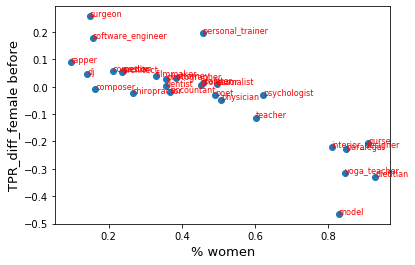

Correlation: -0.17931452924452984; p-value: 0.36123500268793934


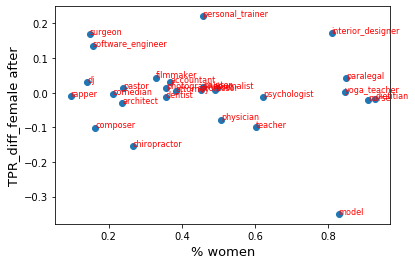

' \nfprs_before, fprs_change_before, mean_ratio_before = get_FPR(y_pred_before, Y_test, p2i, i2p, test_gender)\nsimilarity_vs_tpr(fprs_change_before, word2vec, "before", "FPR", prof2fem)\n\n\nfprs, fprs_change_after, mean_ratio_after = get_FPR(y_pred_after, Y_test, p2i, i2p, test_gender)\nsimilarity_vs_tpr(fprs_change_after, word2vec, "after", "FPR", prof2fem)\n\n#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))\n'

In [37]:
y_pred_before = clf_original.predict(X_dev)
test_gender = [d["g"] for d in test]
dev_gender = [d["g"] for d in dev]

tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, Y_dev, p2i, i2p, dev_gender)
similarity_vs_tpr(tprs_change_before, word2vec, "before", "TPR", prof2fem)


#y_pred_after = clf.predict(X_test.dot(P))
y_pred_after = clf.predict(X_dev.dot(P))
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, Y_dev, p2i, i2p, dev_gender)
similarity_vs_tpr(tprs_change_after, word2vec, "after", "TPR", prof2fem)

 
#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
""" 
fprs_before, fprs_change_before, mean_ratio_before = get_FPR(y_pred_before, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_before, word2vec, "before", "FPR", prof2fem)


fprs, fprs_change_after, mean_ratio_after = get_FPR(y_pred_after, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_after, word2vec, "after", "FPR", prof2fem)

#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
"""


In [ ]:
test_gender

In [18]:
word2vec.most_similar("nurse", topn=30)

[('nurses', 0.8171288967132568),
 ('Nurse', 0.7741500735282898),
 ('nurse-', 0.7292516231536865),
 ('nurse.', 0.7089539766311646),
 ('nursing', 0.6892556548118591),
 ('nurse.The', 0.6736961007118225),
 ('Nurses', 0.6632077097892761),
 ('doctor', 0.6459248065948486),
 ('non-nurse', 0.6306471824645996),
 ('NURSE', 0.6303324699401855),
 ('anesthetist', 0.6228844523429871),
 ('midwife', 0.622739315032959),
 ('nurse.I', 0.6217665672302246),
 ('anurse', 0.6213401556015015),
 ('hospital', 0.6132748126983643),
 ('nures', 0.6075634956359863),
 ('private-duty', 0.596021294593811),
 ('nursie', 0.5875764489173889),
 ('nuring', 0.5859794020652771),
 ('nursing-', 0.5858100056648254),
 ('nurses.', 0.5841954946517944),
 ('physician', 0.5777668952941895),
 ('enfermera', 0.5762297511100769),
 ('nurse-practitioner', 0.5731925368309021),
 ('phlebotomist', 0.5708558559417725),
 ('paramedic', 0.5695872902870178),
 ('Nursing', 0.5675241947174072),
 ('medic', 0.5659814476966858),
 ('pharmacist', 0.56309896707

In [ ]:
test_count = count_profs_and_gender(test)

In [ ]:
test_count